
# Model Interpretation and Evaluation#

In this tutorial, we will explore different methods to evaluate a deep learning (DL) model trained with convective allowing model (CAM) data to classify the occurance of a severe storm report at a given grid point. 

Please cite the notebook as follows:

    Burke, A., 2021: "Model Interpretation and Evaluation"


This tutorial is based off of material from 



    Lagerquist, Ryan, and David John Gagne II, 2020: "Physical interpretation of convolutional neural nets for predicting thunderstorm rotation" 
    https://colab.research.google.com/drive/1ytu_E2_QSkR-gKquZx-tQsKSSzGZSeRA#sandboxMode=true&scrollTo=roTsbwThlKWx 


[Here](https://towardsdatascience.com/list-of-free-must-read-machine-learning-books-89576749d2ff) is a list of free books about ML from a statistical perspective.
 



<br>


# Setup


<br>

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
! pip install netCDF4
%matplotlib inline

import tensorflow as tf
 
#######
# Needed for Saliency, CAMs, BO
!pip install --upgrade tf-keras-vis
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.callbacks import Print
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam import GradcamPlusPlus


import warnings
warnings.filterwarnings('ignore')

### Prevent Auto-scrolling

The next cell prevents output in the notebook from being nested in a scroll box

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;

<IPython.core.display.Javascript object>

## Import data

The next cell imports all of the data that will be used by this notebook. If anything crashes, it will probably be here.

***NOTE: The DL data may take up to a few mintues to load and unzip***

In [ ]:
! wget https://zenodo.org/record/4711025/files/DL_Saved_Training_Values.zip -O DL_Saved_Training_Values.zip
! unzip DL_Saved_Training_Values.zip

! wget https://zenodo.org/record/4711065/files/AMSAI_DL_data.zip -O AMSAI_DL_data.zip
! unzip AMSAI_DL_data.zip	

--2021-06-03 18:30:34--  https://zenodo.org/record/4711025/files/DL_Saved_Training_Values.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23767820 (23M) [application/octet-stream]
Saving to: ‘DL_Saved_Training_Values.zip’

DL_Saved_Training_V 100%[===================>]  22.67M  19.6MB/s    in 1.2s    

2021-06-03 18:30:36 (19.6 MB/s) - ‘DL_Saved_Training_Values.zip’ saved [23767820/23767820]

Archive:  DL_Saved_Training_Values.zip
  inflating: training_max.npy        
  inflating: training_sd.npy         
  inflating: training_min.npy        
  inflating: training_mean.npy       
  inflating: trained_unet_model.h5   
  inflating: trained_cnn_model.h5    
--2021-06-03 18:30:37--  https://zenodo.org/record/4711065/files/AMSAI_DL_data.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.

<br>


# Lecture Overview


<br>

**Brief:** 
1. Prediction Problem
  - Data used to train DL network
2. Data Pre-processing
3. Deep Learning Model Information
  - Includes how I trained UNET model

**More in Depth:**
4. Evaluation Methods
  - Permutation Importance
  - Saliency Maps
  - Class Actvation Maps 
  - Other Methods

# Various Python Functions

These are functions we'll be using in the notebook. 

In [ ]:
# Function to split data based on given years
def split_data_year(predictors,labels,time_data,year_list):
  date_mask = [r for year in year_list for r, row in enumerate(time_data.values) if year in row]
  out_data = predictors[date_mask,:,:,:]
  out_labels = labels[date_mask,:,:,:]        
  return out_data,out_labels 

###########################################################
#load in training data values
train_mean = np.load('training_mean.npy')
train_sd =  np.load('training_sd.npy')
train_min = np.load('training_min.npy')
train_max = np.load('training_max.npy')

#Find outliers greater than 3 standard deviations from the mean
outlier_threshold_value = 3.0*train_sd+train_mean

###########################################################

# Function to reshape and scale input variables   
def reshape_and_scale_predictors(data): 
  # DL model inputs have the predictors last 
  data_shape = data.shape
  scaled_predictors = np.empty((data_shape[0],data_shape[2],data_shape[3],data_shape[1]))
  print(f'Old shape of predictor data: {data_shape}')
  print(f'New shape of predictor data: {scaled_predictors.shape}')

  # #Remove outliers and scale the data using values from the training dataset
  # for pred in np.arange(len(train_mean)):
  #   no_outlier_predictors = np.where(
  #         np.abs(data[:,pred,:,:]) >= outlier_threshold_value[pred], 
  #         train_mean[pred],
  #         data[:,pred,:,:] )
  #   scaled_predictors[:,:,:,pred] = (no_outlier_predictors - train_min[pred])/(train_max[pred]-train_min[pred])
  # return scaled_predictors

  #Scale the data using values from the training dataset
  for pred in np.arange(len(train_mean)):
    scaled_predictors[:,:,:,pred] = (data[:,pred,:,:] - train_min[pred])/(train_max[pred]-train_min[pred])
  return scaled_predictors


<br>


# **1. Prediction Problem**



<br>

![](https://drive.google.com/uc?export=view&id=1sJUWVRQAa1WFUkKL6bHq54KewkjxK4HL)

<img src="https://www.spc.noaa.gov/climo/reports/200502_rpts.gif" width="800">



We are classifying the probability that a single grid point will have a severe storm report at a given forecast hour. This can be expanded to predict if a severe storm report will occur at a grid point at sometime in the future but for the sake of time, we will focus on a single time step at a time. 


- Predictor data from the High Resolution Ensemble Forecast system version 2 ([HREFv2](https://www.spc.noaa.gov/exper/href/?model=href&product=850mb_mean&sector=conus&rd=20200502&rt=1200))
  - The 10 input variables are: the U wind (U), V wind (V), Geopotential Height (GH), Temperature (T), and Dew Point Temperature (DPT) at 850 and 500 hPa 
- Label data from the [Storm Reports Archive](https://www.spc.noaa.gov/climo/reports/200502_rpts.html), a product of the Storm Prediction Center
  - Severe tornado, wind, and hail reports are separated in the label file. We will look at wind for this prediction problem. 
  - They can be separated differently if participants want **(See Section 3)**!



<br>


# **2. Data Pre-processing**




- After loading in the data we will split the it into the **training/testing data sets.**


- We will be using a pretrained UNET and pretrained CNN, but will still split the data here if people choose to train their own networks later on.

## Load in Data

In [ ]:
predictor_data = xr.open_dataset('AMSAI_DL_data/AMSAI_2021_DL_Predictors.nc')
label_data = xr.open_dataset('AMSAI_DL_data/AMSAI_2021_DL_Labels.nc')

print(f'Predictor dataset:\n\n {predictor_data}')
print(f'\n\n\nLabel dataset:\n\n {label_data}')

print(f'\n\nPredictor data shape {predictor_data.Input_Variables.shape}')

Predictor dataset:

 <xarray.Dataset>
Dimensions:          (predictors: 10, time: 8689, x: 64, y: 64)
Coordinates:
  * time             (time) object '170501_fh_2' '170501_fh_6' ... '200831_fh_1'
  * predictors       (predictors) object 'V850' 'V500' ... 'GH850' 'GH500'
  * x                (x) int64 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * y                (y) int64 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
Data variables:
    Input_Variables  (time, predictors, x, y) float64 ...



Label dataset:

 <xarray.Dataset>
Dimensions:        (storm type: 3, time: 8689, x: 64, y: 64)
Coordinates:
  * time           (time) object '170501_fh_2' '170501_fh_6' ... '200831_fh_1'
  * storm type     (storm type) object 'hail' 'torn' 'wind'
  * x              (x) int64 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
  * y              (y) int64 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
Data variables:
    Storm_Reports  (time, storm type, x, y) float64 ...


Predictor d

## Split Data into Subsets

In [ ]:
#If you would like to use other dates, change the 'year_list' parameter

train_predictors, separate_train_labels = split_data_year(
    predictor_data.Input_Variables, label_data.Storm_Reports, 
    predictor_data.time,['17','18','19'])

test_predictors, separate_test_labels = split_data_year(
    predictor_data.Input_Variables, label_data.Storm_Reports, 
    predictor_data.time,['20'])

print(f'Training predictors shape: {train_predictors.shape}')
print(f'Training labels shape: {separate_train_labels.shape}')
print()
print(f'Testing predictors shape: {test_predictors.shape}')
print(f'Testing labels shape: {separate_test_labels.shape}')

Training predictors shape: (7529, 10, 64, 64)
Training labels shape: (7529, 3, 64, 64)

Testing predictors shape: (2566, 10, 64, 64)
Testing labels shape: (2566, 3, 64, 64)


## Normalization and Scaling

Normalizing or scaling data removes issues of variables with different scales
  - Temperature versus sea-level pressure for example

**Important: We normalize/scale our data based on the training data and save these values to apply to testing data**

Details about other transformation methods can be found [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

<br>
<br>

*We will be using a variation of the MinMaxScaler that removes outliers*
  - This is the method I've found works the best, but scale/normalize as you would like!

***MinMaxScaler***

Scalar = $\frac{x_{i} - min(x)}{max(x) - min(x)}$

Scales data between 0 and 1 based on training data minimum and maximum values

In [ ]:
scaled_train_predictors = reshape_and_scale_predictors(train_predictors)
print()
scaled_test_predictors = reshape_and_scale_predictors(test_predictors)

Old shape of predictor data: (7529, 10, 64, 64)
New shape of predictor data: (7529, 64, 64, 10)

Old shape of predictor data: (2566, 10, 64, 64)
New shape of predictor data: (2566, 64, 64, 10)


***Now we're ready to load in the Deep Learning Model and explore how it works!***

<br> 

# **3. Deep Learning Model Information**

The network type we'll be using is a Convolutional Neural Network (CNN)


## Load Trained DL Models

If you would like to simply load an already saved model, run the following line (and not the CNN modeling block)

In [ ]:
# #Load in the UNET and CNN trained model files 
cnn_model = tf.keras.models.load_model('trained_cnn_model.h5')
print(f'\nCNN: {cnn_model}\n')


CNN: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa06a2e1d10>



## Train CNN

(Unless already loading saved model)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers, models
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#######
wind_train_labels = np.nanmax(np.nanmax(separate_train_labels[:,2,:,:],axis=1),axis=-1)
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
encoded_wind_train_label = onehot_encoder.fit_transform(wind_train_labels.reshape(-1, 1))

print(f'Old training labels shape: {separate_train_labels.shape}')
print(f'New training labels shape: {encoded_wind_train_label.shape}')

Old training labels shape: (7529, 3, 64, 64)
New training labels shape: (7529, 2)


In [ ]:
filter_list = [16,32]
cnn_model = models.Sequential()
input_shape = np.shape(scaled_train_predictors[0])
            
            
#First layer: input shape (y,x,# variables) 

#Add noise
cnn_model.add(layers.GaussianNoise(0.01, input_shape=(input_shape)))
for filters in filter_list:
  cnn_model.add(layers.Conv2D(filters, (3,3),padding='same'))
  cnn_model.add(layers.Conv2D(filters, (3,3),padding='same'))
  cnn_model.add(layers.BatchNormalization())
  cnn_model.add(layers.LeakyReLU(alpha=0.3))
  cnn_model.add(layers.MaxPooling2D())
            
#Flatten the last convolutional layer 
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(256))
cnn_model.add(layers.LeakyReLU(alpha=0.3))
cnn_model.add(layers.Dense(2))
cnn_model.add(layers.Softmax())

#Compile neural net
cnn_model.compile(loss=CategoricalCrossentropy(),optimizer=Adam(lr=1e-4))
print(cnn_model.summary())

#Fit the model
n_epochs = 5
bs = 64

conv_hist = cnn_model.fit(scaled_train_predictors,encoded_wind_train_label,batch_size=bs,
      epochs=n_epochs,verbose=1) 

#Save the model
cnn_model_file = 'trained_cnn_model.h5'
print(f'Writing out {cnn_model_file}')
cnn_model.save(cnn_model_file)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        1456      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)       

<br>

# **4. (Non-Exhaustive) Evalutation Methods**



A really useful resource on different methods (not applied to meterorology data) can be found [here](https://mrsalehi.medium.com/a-review-of-different-interpretation-methods-in-deep-learning-part-1-saliency-map-cam-grad-cam-3a34476bc24d) 

## ***Permutation Variable Importance***

A popular method people use for variable importance comes from skearn, called [Feature Importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
  - **NOT Recommended** when data may be correlated

Major two permutation importance functions: 
  - Single-pass
  - Multi-pass

<br> 

### **Single-Pass** 

[Breiman 2001](https://doi.org/10.1023/A:1010933404324)
  - Measures "importance" by a decrease in skill after an individual predictor is shuffled
  - Importance scores are averaged over predictor examples 
  - Important predictors cause a trained ML model to decrease the most in skill when the data are "corrupted" (shuffled/permuted) 

<br>


Scikit Learn developed a single pass perumutation importance package
  - only works on tabular data, cannot be used with tensors (gridded data)

<br> 

**Algorithim** (from [Lagerquist, Ryan, and David John Gagne II, 2020](https://colab.research.google.com/drive/1ytu_E2_QSkR-gKquZx-tQsKSSzGZSeRA#sandboxMode=true&scrollTo=jmyeRkUVlKWT))

Repeat the following for each predictor  $x_j$ :

1. Copy the validation set ( $X$ ) to a new variable,  $X′$ .
2. Permute spatial maps of  $x_j$  over all examples in  $X′$ . 
  - Thus, each map is left spatially intact but assigned to a different examples.
3. Pass  $X′$  through the trained model and record the new loss.

<br>

**Visually** ([GIF credit](https://github.com/alburke/ams-2020-ml-python-course/blob/master/Advanced_Topics_In_Machine_Learning/ML_Model_Interpretation/breiman_permutation.gif) to Amy McGovern)


<img src="https://github.com/alburke/ams-2020-ml-python-course/blob/master/Advanced_Topics_In_Machine_Learning/ML_Model_Interpretation/breiman_permutation.gif?raw=true">



### **Multi-Pass**


[Lakshmanan *et al.* 2015](https://journals.ametsoc.org/view/journals/atot/32/6/jtech-d-13-00205_1.xml)


- Similar to single-pass importance but highly correlated variables are accounted for
- Keep important variables shuffled as the algorithim finds the next most important variable

<br> 

**Algorithim** (from [Lagerquist, Ryan, and David John Gagne II, 2020](https://colab.research.google.com/drive/1ytu_E2_QSkR-gKquZx-tQsKSSzGZSeRA#sandboxMode=true&scrollTo=jmyeRkUVlKWT))

Let $U$ be the set of predictors that are not yet permuted.  At the beginning, $U$ contains all predictors.

 1. For each predictor $x_j$ still in $U$:<br />
    [a] Copy the validation set ($\mathbf{X}$) to a new variable, $\mathbf{X'}$.<br />
    [b] Permute spatial maps of $x_j$ over all examples in $\mathbf{X'}$.<br />
    [c] Pass $\mathbf{X'}$ through the trained model and record the new loss.
 2. Find the predictor whose permutation in step 1 leads to the highest loss.  This is the most important predictor remaining in $U$.  Call it $x^*$.
 3. Remove $x^*$ from $U$ and permanently permute $x^*$ in the validation set $\mathbf{X}$.
 4. Repeat steps 1-3 until all predictors are permuted.

<br>

**Visually** ([GIF credit]("https://github.com/alburke/ams-2020-ml-python-course/blob/master/Advanced_Topics_In_Machine_Learning/ML_Model_Interpretation/lak_permutation.gif) to Amy McGovern)

<img src="https://github.com/alburke/ams-2020-ml-python-course/blob/master/Advanced_Topics_In_Machine_Learning/ML_Model_Interpretation/lak_permutation.gif?raw=true">



In [ ]:
#only look at the first 100 examples to save time
cnn_wind_test_labels = np.nanmax(np.nanmax(separate_test_labels[:100,2,:,:],axis=1),axis=-1)
print(f'Old testing labels shape: {separate_test_labels.shape}')
print(f'New testing labels shape: {cnn_wind_test_labels.shape}')

Old testing labels shape: (2566, 3, 64, 64)
New testing labels shape: (100,)


In [ ]:
# We will be using MSE for our skill score to determine the important variables
from sklearn.metrics import mean_squared_error

preds = cnn_model.predict(scaled_test_predictors[:100,:,:,:])[:,0]
original_skill_score = mean_squared_error(cnn_wind_test_labels, preds)
print(f'Original MSE score on unpermuted data: {original_skill_score}')

Original MSE score on unpermuted data: 0.3645488575518314


In [ ]:
# Now lets shuffle each variable and see what happens to the skill score
np.random.seed(4)
single_pass_score_differnces = {}
for v,variable in enumerate(predictor_data.predictors.values):
  copied_test_data = scaled_test_predictors[:100,:,:,:].copy()
  print(f'Variable we are shuffling {variable}')
  copied_test_data[:,:,:,v] = np.random.permutation(scaled_test_predictors[:100,:,:,v])
  shuffled_preds = cnn_model.predict(copied_test_data)[:,0]
  shuffled_score = mean_squared_error(cnn_wind_test_labels,shuffled_preds)
  single_pass_score_differnces[variable] = original_skill_score-shuffled_score
  del copied_test_data

Variable we are shuffling V850
Variable we are shuffling V500
Variable we are shuffling U850
Variable we are shuffling U500
Variable we are shuffling T850
Variable we are shuffling T500
Variable we are shuffling DPT850
Variable we are shuffling DPT500
Variable we are shuffling GH850
Variable we are shuffling GH500


In [ ]:
print(single_pass_score_differnces)
index_greatest_skill_loss = np.argmin(list(single_pass_score_differnces.values()))
important_variable = predictor_data.predictors.values[index_greatest_skill_loss]
print(f'Most important variable from single-pass: {important_variable}')

{'V850': 0.01259118472280446, 'V500': 0.035876556515690605, 'U850': 0.007581660472548768, 'U500': -0.002125962805587134, 'T850': 0.012817436294267903, 'T500': -0.0005199894813641692, 'DPT850': 0.005045686517981152, 'DPT500': 0.01992387431464565, 'GH850': 0.029796572350873463, 'GH500': 0.005150533790162393}
Most important variable from single-pass: U500


In [ ]:
# Now lets shuffle each variable and see what happens to the skill score
np.random.seed(4)

multipass_important_variables = []
n_important_vars = np.arange(3)
shuffle_indices = []

variable_list = list(predictor_data.predictors.values)
for n in n_important_vars:
  multipass_score_differnces = {}
  print(f'Finding important variable: {n}')
  print('Shuffled indices:')
  for v,variable in enumerate(variable_list):
    v = shuffle_indices +[v]
    print(v)
    copied_test_data = scaled_test_predictors[:100,:,:,:].copy()
    copied_test_data[:,:,:,v] = np.random.permutation(scaled_test_predictors[:100,:,:,v])
    shuffled_preds = cnn_model.predict(copied_test_data)[:,0]
    shuffled_score = mean_squared_error(cnn_wind_test_labels,shuffled_preds)
    multipass_score_differnces[variable] = original_skill_score-shuffled_score
    del copied_test_data
  index_greatest_skill_loss = np.argmin(list(multipass_score_differnces.values()))
  shuffle_indices.append(index_greatest_skill_loss)
  important_variable = np.array(variable_list)[index_greatest_skill_loss]
  variable_list.remove(important_variable)
  multipass_important_variables.append(important_variable)



print(f'Top {len(n_important_vars)} important variables: {multipass_important_variables}')

Finding important variable: 0
Shuffled indices:
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
Finding important variable: 1
Shuffled indices:
[3, 0]
[3, 1]
[3, 2]
[3, 3]
[3, 4]
[3, 5]
[3, 6]
[3, 7]
[3, 8]
Finding important variable: 2
Shuffled indices:
[3, 5, 0]
[3, 5, 1]
[3, 5, 2]
[3, 5, 3]
[3, 5, 4]
[3, 5, 5]
[3, 5, 6]
[3, 5, 7]
Top 3 important variables: ['U500', 'DPT850', 'DPT500']


##Neural Network Interpretability 







The rest of the methods do not delve deeply into the inputs or outputs of a DL network. Instead they example the ***hidden layers*** and how each hidden neuron ***fires*** or ***activates***. 

<br>

Neural networks are based on the processes behind neurons in the brain. If a certain neuron ***fires*** then information is passed along it. Otherwise  the information stops there. 


<img src="https://i.pinimg.com/originals/1c/63/b5/1c63b58aa68d9fee506e2397d05598e2.gif" width="800">

[Image credit](https://www.dailymail.co.uk/sciencetech/article-2581184/The-dynamic-mind-Stunning-3D-glass-brain-shows-neurons-firing-real-time.html)


<br>

Similarly, only a hidden layer neuron that ***fires*** or ***activates*** passes along information.

In DL models that take 2D or 3D data as inputs, these neurons can activate not only in space but bewteen each channel too. 


<img src="http://i.gzn.jp/img/2018/03/12/neural-network-interpretability/snap1144_m.png" width="800">

[Image credit](https://gigazine.net/gsc_news/en/20180312-neural-network-interpretability/)

A fun site that allows users to play with interpretating data in real time can be found [here](https://distill.pub/2018/building-blocks/)

**NOTE:  There are a lot of good visualizations at https://distill.pub that I recommend looking at (and will post links to). I personally find them not only informative but fun as well.**

(1, 64, 64, 10)


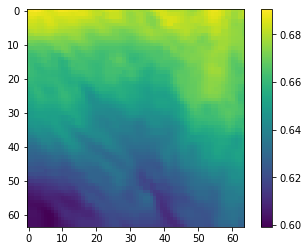

In [ ]:
test_image_to_examine = scaled_test_predictors[120:121,:,:,:]
print(test_image_to_examine.shape)
plt.imshow(test_image_to_examine[0,:,:,8])
plt.colorbar()
plt.show()

### ***Saliency Maps***



[Simonyan *et al.* 2014](https://arxiv.org/pdf/1312.6034.pdf) use saliency to rank each pixel within an image based on how much it contributes to a models classification. 

<br> 
For a trained linear model where,

$I$: input image (flattened to a 1D)

$y$: output prediction

$w$: weights, similar to coefficients in linear regression

$b$: bias term, similar to adding noise

<br>

$y = w^{T}I + b$

<br>

The weights would be learned and represent a value multipled for a given pixel in $I$. The higher the weight, the more its represented when making a prediciton. 

However, DL models are nonlinear and cannot be exactly approximated this way. To determine the weight matrix ($w$) or saliency of the nonlinear model we take the derivative of the output class at every input pixel,

<br>
<br>

**Saliency** = $w = \frac{\partial y}{\partial I} \bigg \rvert_{I = I_0}$
with $I_0$ being an individual point. 

<br>
<br>

In laymens terms, we want to see how an output will change with small changes in the input. 


This creates a heatmap of values, where the higher the value at a given pixel, the more it contributed to the output prediction of a certain class. An intuitive explanation can be found [here](https://glassboxmedicine.com/2019/06/21/cnn-heat-maps-saliency-backpropagation/)


Below we see a saliency map (heatmap) showing that the cats paws and some of the background are important in determining the label 'cat' with this image.

<img src="https://usmanr149.github.io/urmlblog/images/saliencyMap/output_13_1.png" width="800">

[Image Credit](https://usmanr149.github.io/urmlblog/cnn/2020/05/01/Salincy-Maps.html)





 

<!-- 

"Semantic dictionaries give us a fine-grained look at an activation: what does each single neuron detect? Building off this representation, we can also consider an activation vector as a whole. Instead of visualizing individual neurons, we can instead visualize the combination of neurons that fire at a given spatial location. (Concretely, we optimize the image to maximize the dot product of its activations with the original activation vector.)"

"Saliency maps implicitly slice our cube of activations by applying attribution to the spatial positions of a hidden layer. This aggregates over all channels and, as a result, we cannot tell which specific detectors at each position most contributed to the final output classification."

"The most common interface for attribution is called a saliency map — a simple heatmap that highlights pixels of the input image that most caused the output classification. We see two weaknesses with this current approach."

# Interpretation method 2: Saliency maps

Saliency (Simonyan *et al.* 2014) is defined by the following derivative:

$s = \frac{\partial a}{\partial x} \bigg \rvert_{x = x_0}$

 - $a$ is the activation of a neuron in the model
 - $x$ is a scalar predictor (one variable at one grid point)
 - $x_0$ is the value of $x$ in a real example

Thus, saliency is an approximation of $\frac{\partial a}{\partial x}$, linearized around the $x$-value that occurs in the example.  This can be computed for all scalar predictors $x$, resulting in a map.

$a$ is often the activation of an output neuron, which is a prediction.  In this notebook, there is only one output neuron and its activation is probability of strong future rotation.  Thus, our saliency maps quantify the sensitivity of strong-rotation probability to each input, answering the question "How could the storm be perturbed to increase/decrease the likelihood of strong future rotation?"

However, $a$ could also be of the following (figure from https://distill.pub/2018/building-blocks/):

 - Activation of inner neuron (in a convolutional or dense layer)
 - Mean/max activation of all neurons in a channel
 - Mean/max activation of all neurons in a layer
 - Mean/max activation of all neurons at one spatial location

[Figure with schematic of model components](https://raw.githubusercontent.com/alburke/ams-2020-ml-python-course/master/Advanced_Topics_In_Machine_Learning/model_components.png) -->



<br> 

For our case, since we're predicitng all severe weather occurence, the question we solve is: 

**What parts of an image (any one of our variables) are important for severe weather report prediction?**

<br>

We can apply these principles with relatively few lines of code. This is a good way to see what parts of an image a DL network is focusing on, which helps interpretation but also debugging!

In [ ]:
# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(1, 2)` i.e., (samples, classes).
def loss(output):
    # print(output.shape)
    return (output[0][0])

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

(1, 64, 64, 10)


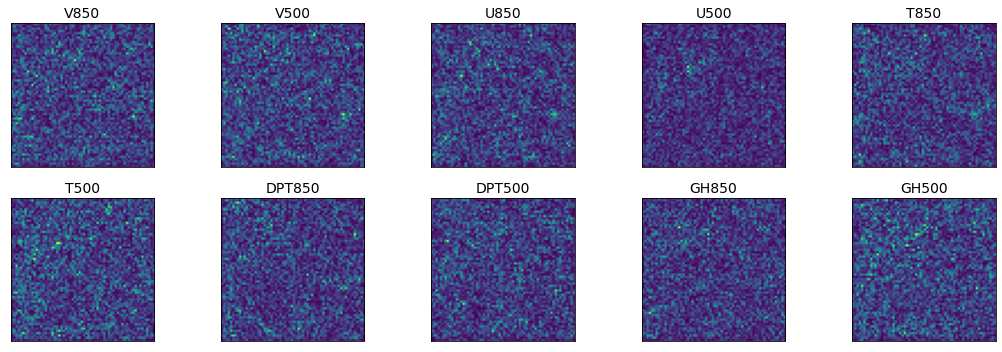

In [ ]:
# Create Saliency object.
saliency = Saliency(cnn_model,
                    model_modifier=model_modifier,
                    clone=False)

# # Generate saliency map
saliency_map = saliency(loss, test_image_to_examine, keepdims=True)
saliency_map = normalize(saliency_map)
print(np.shape(saliency_map))

titles = predictor_data.predictors.values
# # Render
subplot_args = { 'nrows': 2, 'ncols': 5, 'figsize': (15, 5),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
fig, axes = plt.subplots(**subplot_args)

for i, ax in enumerate(axes.ravel()):
    ax.set_title(titles[i], fontsize=14)
    ax.imshow(saliency_map[0,:,:,i])
plt.tight_layout()
plt.show()

### ***Class Actvation Maps (CAMs)***


Class activation [Zhou *et al.* 2016](https://arxiv.org/pdf/1512.04150.pdf) is very similar to saliency maps, with a few key differences: 


Key differences between saliency and class activation:

 1. Class activation shows which neurons are fired at every grid point *averaged over all predictors*. Saliency looks at neurons firing at every grid point and predirctor seperately. 
   - Thus, class activation yields only one map, instead of one per predictor variable.<br />

 3. Class activation highlights the values most important for the model's actual prediction; saliency highlights the values most important for changing the model's prediction.<br />
 4. Class activation is different for each convolutional layer.
   - CAMs produced by deeper conv layers are generally smoother and have large values confined to a smaller part of the image.
   - This is because deeper layers contain larger-scale features and more abstraction.

We use a method called Grad-CAM (gradient-weighted class-activation maps; Selvaraju *et al.* 2017), because the original method (Zhou *et al.* 2016) works only for a particular CNN architecture, which we do not have.

A really good website that goes into the theory more can be found [here](https://fairyonice.github.io/Grad-CAM-with-keras-vis.html)

**First look at GradCAM**



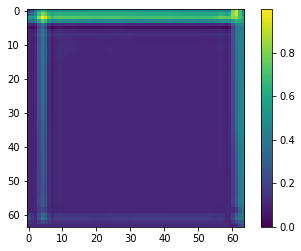

CPU times: user 268 ms, sys: 1.04 ms, total: 269 ms
Wall time: 271 ms


In [ ]:
%%time

# Create Gradcam object
gradcam = Gradcam(cnn_model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              test_image_to_examine,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

plt.imshow(cam[0]) 
plt.colorbar()
plt.show()


**Now look at GradCAM++**

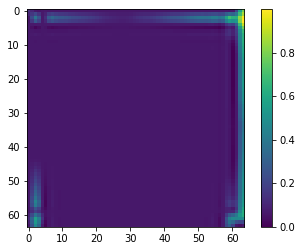

CPU times: user 259 ms, sys: 8.99 ms, total: 268 ms
Wall time: 264 ms


In [ ]:
%%time

# Create Gradcam++ object
gradcam = GradcamPlusPlus(cnn_model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              test_image_to_examine,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

plt.imshow(cam[0]) 
plt.colorbar()
plt.show()


### ***Backwards Optimization***


Backwards optimization (Erhan *et al.* 2009) goes by many names:

 - Feature optimization
 - Activation maximization
 - Optimal input

Backwards optimization creates a synthetic input example that minimizes or maximizes the activation of a given neuron.  As for saliency, we will use only the output neuron, whose activation is probability of strong future rotation.

The procedure is basically training in reverse:

 - During training, gradient descent is used to minimize the loss function by adjusting model weights.
 - During backwards optimization, gradient descent is used to minimize/maximize neuron activation by adjusting model inputs (predictors).
 - If the goal is to maximize strong-rotation probability, we create an optimal rotating storm.
 - If the goal is to minimize strong-rotation probability, we create an optimal non-rotating storm.

Like training, backwards optimization is an iterative procedure.  At each iteration the synthetic example is updated via the following rule.

$\mathbf{X} \leftarrow \mathbf{X} - \alpha \frac{\partial J}{\partial \mathbf{X}}$

 - $\mathbf{X}$ is the input tensor (multi-dimensional matrix with predictors)
 - $\alpha$ is the learning rate (user-determined)
 - $J$ is the loss function

In the simplest framework, $J = (p - p^*)^2$, where $p$ is the current probability and $p^*$ is the desired probability (0.0 or 1.0).  Thus, the above equation can be written as follows:

$\mathbf{X} \leftarrow \mathbf{X} - 2\alpha (p - p^*) \frac{\partial p}{\partial \mathbf{X}}$

In [ ]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((1, 64, 64, 10), 0, 255)

activation_maximization = ActivationMaximization(cnn_model,
                                                 model_modifier,
                                                 clone=False)

In [ ]:
%%time

# Do 500 iterations and Generate an optimizing animation
activations = activation_maximization(loss,
                                    seed_input=seed_input,
                                    steps=512,
                                    callbacks=[ Print(interval=50)])
activation_images = np.array([activation.astype(np.uint8) for activation in activations])


Steps: 050	Scores: [0.0],	Regularizations: [('TotalVariation2D', [4.330112457275391]), ('Norm', [0.5770010948181152])]
Steps: 100	Scores: [0.0],	Regularizations: [('TotalVariation2D', [6.452075958251953]), ('Norm', [0.5443512201309204])]
Steps: 150	Scores: [0.0],	Regularizations: [('TotalVariation2D', [5.701645851135254]), ('Norm', [0.5117648839950562])]
Steps: 200	Scores: [0.0],	Regularizations: [('TotalVariation2D', [3.1528186798095703]), ('Norm', [0.4794495701789856])]
Steps: 250	Scores: [0.0],	Regularizations: [('TotalVariation2D', [3.9907729625701904]), ('Norm', [0.44915732741355896])]
Steps: 300	Scores: [0.0],	Regularizations: [('TotalVariation2D', [3.113227367401123]), ('Norm', [0.4166813790798187])]
Steps: 350	Scores: [0.0],	Regularizations: [('TotalVariation2D', [3.672513484954834]), ('Norm', [0.3846963942050934])]
Steps: 400	Scores: [0.0],	Regularizations: [('TotalVariation2D', [4.293746471405029]), ('Norm', [0.3538571000099182])]
Steps: 450	Scores: [0.0],	Regularizations: [(

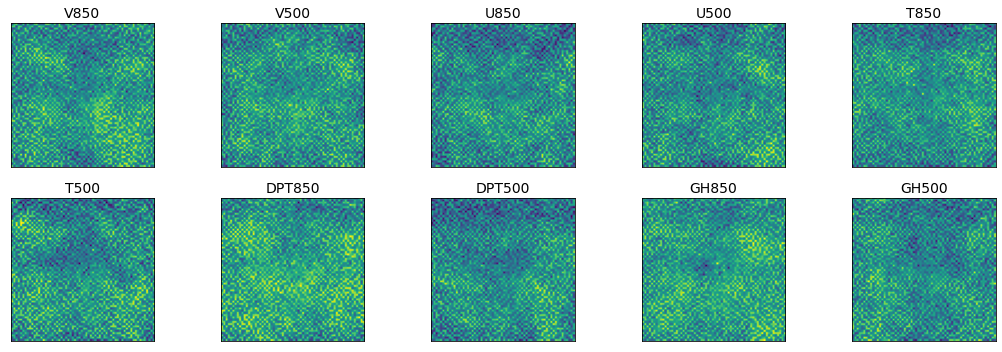

In [ ]:
title_list = predictor_data.predictors.values
# # Render
subplot_args = { 'nrows': 2, 'ncols': 5, 'figsize': (15, 5),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
fig, axes = plt.subplots(**subplot_args)

for i, ax in enumerate(axes.ravel()):
    ax.set_title(title_list[i], fontsize=14)
    ax.imshow(activation_images[0,:,:,i])
plt.tight_layout()
plt.show()

## Other Interesting Methods

- [Layerwise Relevance Propagation](https://towardsdatascience.com/indepth-layer-wise-relevance-propagation-340f95deb1ea)
 * Wont go into code for this method because of issues with tensorflow versions with the rest of the notebook. The iNNvestigate module is well documented and nicely written, howver it requires tensorflow 1.2 and this breaks with the rest of the packages. To get this package run: 

  ```
  ! python -m pip install git+https://github.com/albermax/innvestigate.git
  import innvestigate
  ```

- [Partial-dependence plots](https://christophm.github.io/interpretable-ml-book/pdp.html)

- [Novely Detection](https://www.dlology.com/blog/how-to-do-novelty-detection-in-keras-with-generative-adversarial-network-part-2/)
